# Setup


## Jupyter extensions


In [2]:
%load_ext autoreload
%autoreload 2
%cd ..
%pwd

/home/oli/Research/interpreting-rewards/code


'/home/oli/Research/interpreting-rewards/code'

In [3]:
#start by adding parent directory...
import os
import sys
import inspect

from matplotlib import pyplot as plt

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(-1, parentdir) 
# Now build environment
# import numpy as np
import torch
import numpy
import primitives as prim
from environs import GridWorld
from utils import broadcompress

GW = GridWorld.make(11,8, noise=0.1)


# R0pt.require_grad()

# Sanity Checks

## A Demonstration of $\partial_R \pi^*_R$
Compute the directional derivitives of $\pi^*$ for the reward $R$ in for each of the constant policy actions.

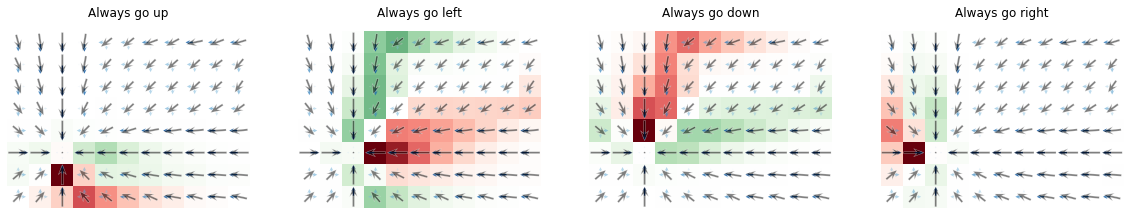

In [4]:

fig, ax = plt.subplots(1, len(GW.A), sharex=True, sharey=True, figsize=(20,5))
for ia, (a, axa) in enumerate(zip(GW.A.ordered, ax)):

    R0pt = torch.zeros(GW.Sshape)
    R0pt[21] = 1
    # R0pt[44] = 1
    R0pt.requires_grad = True

    piopt = prim.fwd(GW, R0pt, 0.99, temp=0.001, val_iters=100)

    always_do_a = torch.zeros(GW.SAshape)
    always_do_a[:, ia, :] = 1

    axa.set_title("Always go "+a)
    piopt.backward(always_do_a)
    GW.draw(states=R0pt.grad, policy=piopt, ax=axa)

    del R0pt

#### Observations: 

**Rationalization of the asymmetry.**  Adding a small amount of reward above the desired spot won't keep the optimal policy from going down, but a negative reward underneath will ensure that the adjacent squares should go up rather than randomizing 50/50. 


Prediction: we can iterate this to get a desired policy, doing IRL 


## Demonstrating derivative of value with respect to reward

In [30]:
vstar = prim.value_iter(GW, R0pt, 0.99, temperature=0.01)
vstar.requires_grad

True

# MCE-IRL with Torch

In [56]:

def torch_IRL(env, desired_policy, gamma, iters=100, loss_fn='-sim', lr=0.001):
    # the parameters are the rewards.
    # start with the zero reward
    R = torch.zeros(env.SAshape, requires_grad = True)

    optimizer = torch.optim.Adam([R], lr=lr)
    losses = []

    for it in range(iters):
        optimizer.zero_grad()
        opt_policy = prim.fwd(GW, R, gamma, temp=0.001, val_iters=100)

        ## negative similarity loss
        if loss_fn == '-sim':
            loss = - (desired_policy * opt_policy).sum() / torch.sqrt((desired_policy**2).sum() + (opt_policy**2).sum())
        ## KL DIV
        if loss_fn == 'kl':
            loss = (desired_policy * torch.where(desired_policy==0, 0., torch.log(torch.div(desired_policy, opt_policy)))).sum()
        if loss_fn == 'sq':
            loss = ((desired_policy - opt_policy)**2).sum()
        loss.backward()
        losses.append(loss.detach())

        optimizer.step()

    # torch_IRL.losses = losses
    return R.detach(), losses

## IRL for a deterministic policy

MSE:  tensor(6.3982e-08, dtype=torch.float64)


Text(0.5, 1.0, 'traininc curve: negative similarity loss')

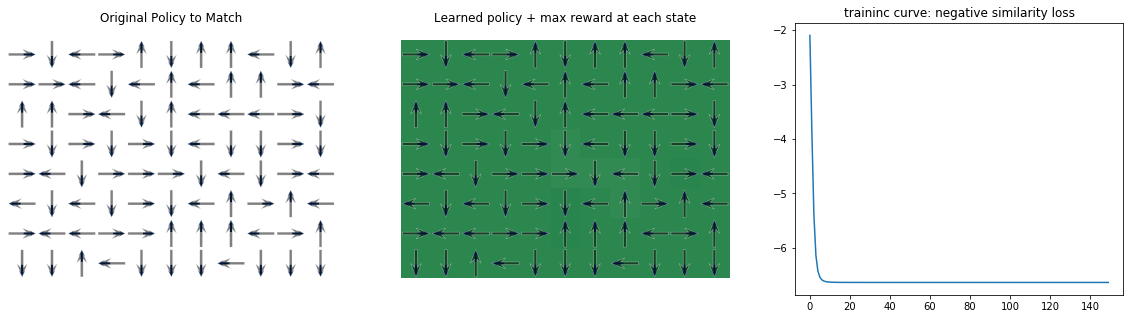

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

pi = GW.random_policy(det=True)
GW.draw(policy=pi,  ax=ax1)
R, losses = torch_IRL(GW, pi, 0.999, iters=150, loss_fn='-sim', lr=0.0005)
piopt = prim.fwd(GW, R, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=piopt, states=R.numpy().max(axis=1), ax=ax2)

print("MSE: ", ((piopt - pi)**2).sum() )

ax3.plot(losses)

ax1.set_title("Original Policy to Match")
ax2.set_title("Learned policy + max reward at each state")
ax3.set_title("traininc curve: negative similarity loss")

## IRL for The optimal policy for the point reward

MSE:  tensor(101.2929, dtype=torch.float64)


Text(0.5, 1.0, 'training curves')

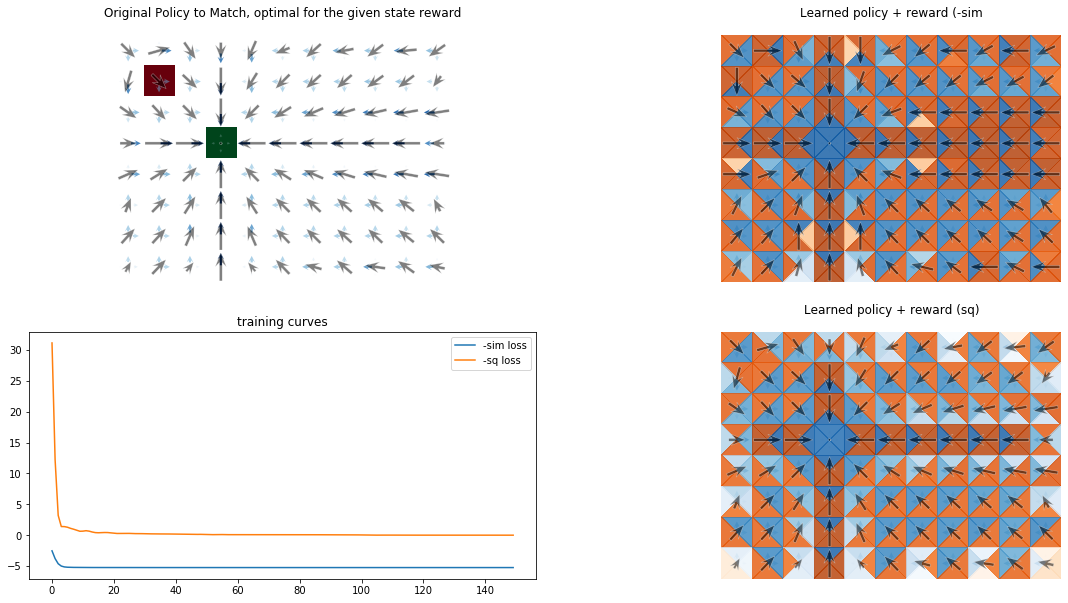

In [58]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(20,10))


R_dipole = torch.zeros(GW.Sshape)
R_dipole[GW.S.idx(('x3', 'y3'))] = 1
R_dipole[GW.S.idx(('x1', 'y1'))] = -1

pi = prim.fwd(GW, R_dipole, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=pi, states=broadcompress(R_dipole), ax=ax1)
R_sim, losses_sim = torch_IRL(GW, pi, 0.999, iters=150, loss_fn='-sim', lr=0.0005)
R_sq, losses_sq = torch_IRL(GW, pi, 0.999, iters=150, loss_fn='sq', lr=0.0005)
piopt1 = prim.fwd(GW, R_sim, 0.999, temp=0.001, val_iters=100)
piopt2 = prim.fwd(GW, R_sq, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=piopt1, tris=R_sim.numpy(), ax=ax2)
GW.draw(policy=piopt2, tris=R_sq.numpy(), ax=ax4)

print("MSE: ", ((piopt - pi)**2).sum() )

ax3.plot(losses_sim, label="-sim loss")
ax3.plot(losses_sq, label="-sq loss")
ax3.legend()

# ax3.semilogy(torch_MCE_IRL.losses - numpy.min(torch_MCE_IRL.losses)+1)

ax1.set_title("Original Policy to Match, optimal for the given state reward")
ax2.set_title("Learned policy + reward (-sim")
ax4.set_title("Learned policy + reward (sq)")
ax3.set_title("training curves")

Let's try the entropy-regularized version of that.

MSE:  tensor(18.0085, dtype=torch.float64)


Text(0.5, 1.0, 'traininc curve: -sim loss')

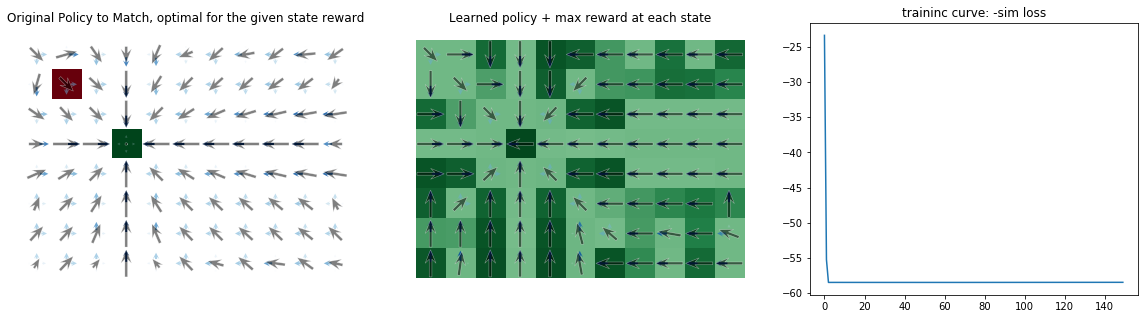

In [59]:
def entropy_regularized_torch_IRL(env, desired_policy, gamma, iters=100, loss_fn='-sim'):
    # the parameters are the rewards.
    # start with the zero reward
    R = torch.zeros(env.SAshape, requires_grad = True)

    optimizer = torch.optim.Adam([R], lr=0.01)
    losses = []

    for it in range(iters):
        optimizer.zero_grad()
        opt_policy = prim.fwd(GW, R, gamma, temp=0.001, val_iters=100)

        ## negative similarity loss
        if loss_fn == '-sim':
            loss = (- desired_policy * opt_policy).sum()
        ## KL DIV
        if loss_fn == 'kl':
            loss = - (desired_policy * opt_policy).sum() / torch.sqrt((desired_policy**2).sum() + (opt_policy**2).sum())
        if loss_fn == 'sq':
            loss = ((desired_policy - opt_policy)**2).sum()
            
        loss += torch.where(opt_policy==0, 0., opt_policy*torch.log(torch.where(opt_policy==0, 1., opt_policy))).sum() / GW.nS
        loss.backward()
        losses.append(loss.detach())

        optimizer.step()

    return R.detach(), losses

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

R_dipole = torch.zeros(GW.Sshape)
R_dipole[GW.S.idx(('x3', 'y3'))] = 1
R_dipole[GW.S.idx(('x1', 'y1'))] = -1

pi = prim.fwd(GW, R_dipole, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=pi, states=broadcompress(R_dipole), ax=ax1)
R, losses = entropy_regularized_torch_IRL(GW, pi, 0.999, iters=150, loss_fn='-sim')
piopt = prim.fwd(GW, R, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=piopt, states=R.numpy().max(axis=1), ax=ax2)

print("MSE: ", ((piopt - pi)**2).sum() )

ax3.plot(losses)
# ax3.semilogy(torch_MCE_IRL.losses - numpy.min(torch_MCE_IRL.losses)+1)

ax1.set_title("Original Policy to Match, optimal for the given state reward")
ax2.set_title("Learned policy + max reward at each state")
ax3.set_title("traininc curve: -sim loss")

# Regularized IRL

In [18]:
def regularized_torch_IRL(env, desired_policy, γ, iters=100, lr=0.001, goal_dir_coeff=1, loss_fn='cos'):
    # the parameters are the rewards.
    # start with the zero reward
    R = torch.zeros(env.SAshape, requires_grad = True)

    optimizer = torch.optim.Adam([R], lr=lr)
    losses = []
    
    for it in range(iters):
        optimizer.zero_grad()
        # V = prim.value_iter(GW, R, γ, 100, temperature=0.001)
        # opt_policy = prim.best_policy(GW, R, V, γ, temperature=0.001)
        opt_policy = prim.fwd(GW, R, γ, val_iters=100, temp=0.001)

        # kl = (dp * torch.where(dp==0, 0., torch.log( torch.where(dp==0, 1., torch.div(dp, opt_policy+1e-8))))).sum()
        # mse = ((dp - opt_policy)**2).sum()
       
        loss = 0
        dp = desired_policy
        if 'cos' in loss_fn:  ## cosine similarity loss.
            loss = -(dp * opt_policy).sum() / torch.sqrt( (dp**2).sum() * (opt_policy**2).sum())
        if 'kl' in loss_fn: ##
            loss += (dp * torch.where(dp==0, 0., torch.log( torch.where(dp==0, 1., torch.div(dp, opt_policy+1e-8))))).sum()
        if 'sq' in loss_fn: ## square loss
            loss += ((dp - opt_policy)**2).sum()

        ratio = 0.1
        γsmall = γ * ratio
        γbig = 1 + (γ - 1)*ratio
        # print('small \gamma: ',γsmall, ' \t big gamma:', γbig)
        policy_bigg = prim.fwd(GW, R, γbig, val_iters=100, temp=0.001)
        policy_smallg = prim.fwd(GW, R, γsmall, val_iters=100, temp=0.001)

        ## Goal Directedness Regularization (cost for similarity)
        loss += goal_dir_coeff * (policy_bigg * policy_smallg).sum() / torch.sqrt( (policy_bigg**2).sum() * (policy_smallg**2).sum()) 
        ## L1 regularization
        # loss += torch.abs(R.sum(axis=1)).sum()
        ## Entropy Regularization
        # loss += 2* torch.where(opt_policy==0, 0., opt_policy*torch.log(torch.where(opt_policy==0, 1., opt_policy))).sum() / GW.nS

        loss.backward()
        losses.append(loss.detach())

        optimizer.step()

    return R.detach(), losses

## Cosine Similarity Loss

### For regualrization strength $\epsilon = 2$

MSE:  tensor(19.6025, dtype=torch.float64)


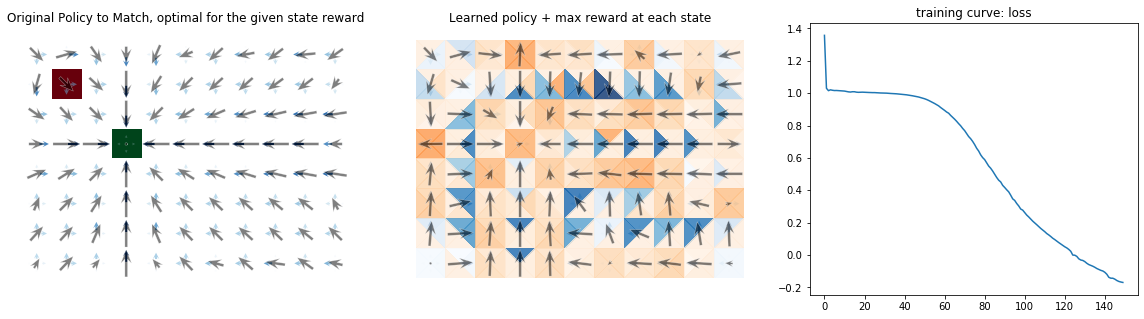

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

R_dipole = torch.zeros(GW.Sshape)
R_dipole[GW.S.idx(('x3', 'y3'))] = 1
R_dipole[GW.S.idx(('x1', 'y1'))] = -1

pi = prim.fwd(GW, R_dipole, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=pi, states=broadcompress(R_dipole), ax=ax1)
R, losses = regularized_torch_IRL(GW, pi, 0.999, iters=150, goal_dir_coeff=2)
piopt = prim.fwd(GW, R, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=piopt, tris=R.numpy(), ax=ax2)

print("MSE: ", ((piopt - pi)**2).sum() )

ax3.plot(losses)
# ax3.semilogy(torch_MCE_IRL.losses - numpy.min(torch_MCE_IRL.losses)+1)

ax1.set_title("Original Policy to Match, optimal for the given state reward")
ax2.set_title("Learned policy + max reward at each state")
ax3.set_title("training curve: loss")
plt.show()

### For regualrization strength $\epsilon = 0.5$

MSE:  tensor(0.9009, dtype=torch.float64)


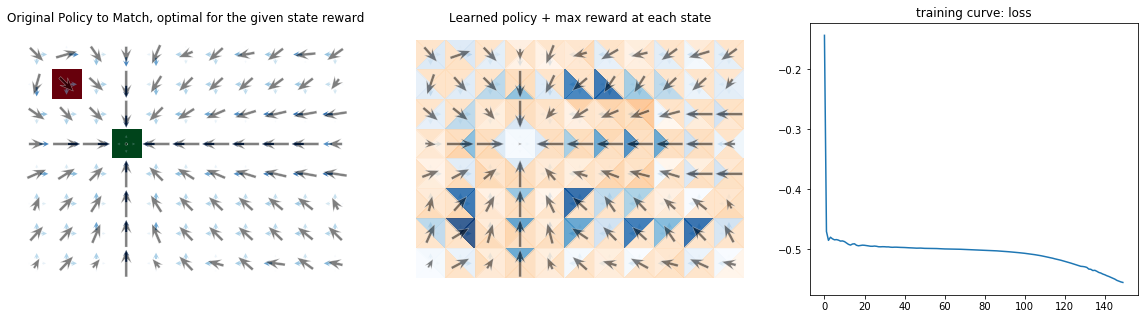

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

R_dipole = torch.zeros(GW.Sshape)
R_dipole[GW.S.idx(('x3', 'y3'))] = 1
R_dipole[GW.S.idx(('x1', 'y1'))] = -1

pi = prim.fwd(GW, R_dipole, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=pi, states=broadcompress(R_dipole), ax=ax1)
R, losses = regularized_torch_IRL(GW, pi, 0.999, iters=150, goal_dir_coeff=2)
piopt = prim.fwd(GW, R, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=piopt, tris=R.numpy(), ax=ax2)

print("MSE: ", ((piopt - pi)**2).sum() )

ax3.plot(losses)
# ax3.semilogy(torch_MCE_IRL.losses - numpy.min(torch_MCE_IRL.losses)+1)

ax1.set_title("Original Policy to Match, optimal for the given state reward")
ax2.set_title("Learned policy + max reward at each state")
ax3.set_title("training curve: loss")
plt.show()

### For regularization strength $\epsilon = 100$

MSE:  tensor(61.7158, dtype=torch.float64)


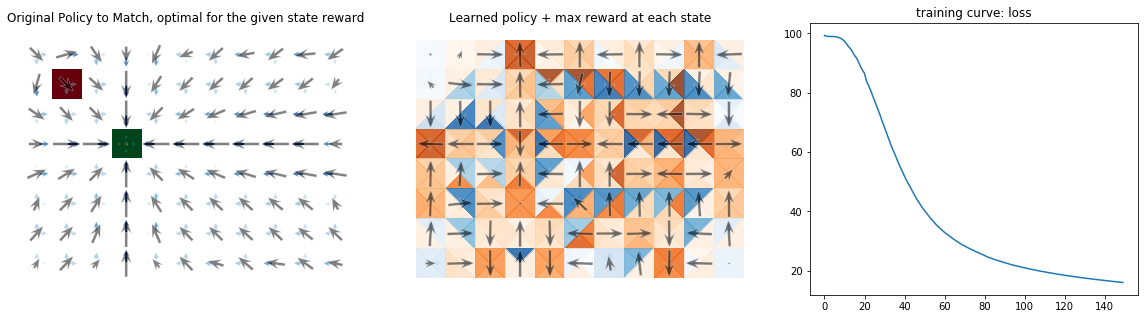

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

R_dipole = torch.zeros(GW.Sshape)
R_dipole[GW.S.idx(('x3', 'y3'))] = 1
R_dipole[GW.S.idx(('x1', 'y1'))] = -1

pi = prim.fwd(GW, R_dipole, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=pi, states=broadcompress(R_dipole), ax=ax1)
R, losses = regularized_torch_IRL(GW, pi, 0.999, iters=150, goal_dir_coeff=100)
piopt = prim.fwd(GW, R, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=piopt, tris=R.numpy(), ax=ax2)

print("MSE: ", ((piopt - pi)**2).sum() )

ax3.plot(losses)
# ax3.semilogy(torch_MCE_IRL.losses - numpy.min(torch_MCE_IRL.losses)+1)

ax1.set_title("Original Policy to Match, optimal for the given state reward")
ax2.set_title("Learned policy + max reward at each state")
ax3.set_title("training curve: loss")
plt.show()

## All Three Losses


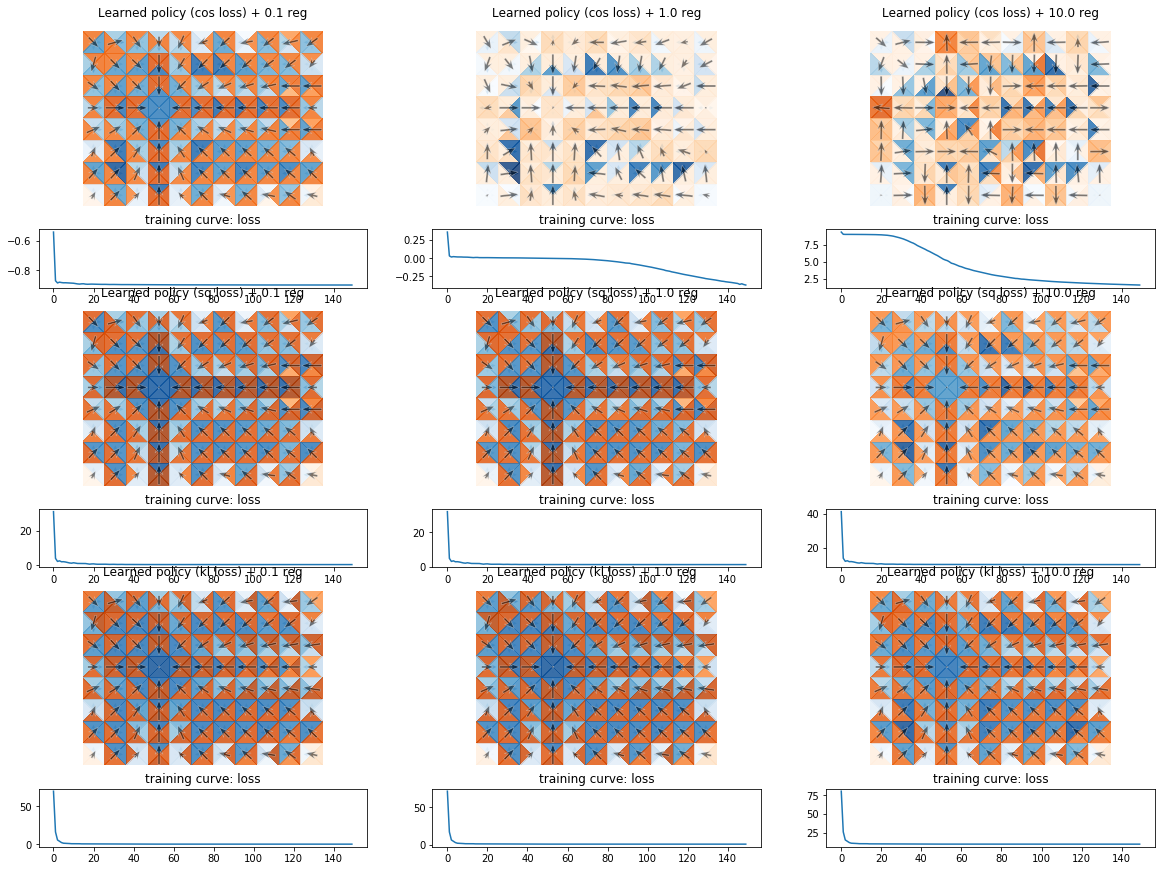

In [19]:
fig, AX = plt.subplots(6, 3, figsize=(20,15),  gridspec_kw={'height_ratios': [3,1,3,1,3,1]})

R_dipole = torch.zeros(GW.Sshape)
R_dipole[GW.S.idx(('x3', 'y3'))] = 1
R_dipole[GW.S.idx(('x1', 'y1'))] = -1

pi = prim.fwd(GW, R_dipole, 0.999, temp=0.001, val_iters=100)
# GW.draw(policy=pi, states=broadcompress(R_dipole), ax=ax?)
# ax?.set_title("Original Policy to Match, optimal for the given state reward")

for r,loss_fn in enumerate(['cos','sq','kl']):
    for c,gdc in enumerate([0.1,1, 10]):
        ax_r = AX[2*r,c]
        ax_tr = AX[2*r+1,c]

        R, losses = regularized_torch_IRL(GW, pi, 0.999, iters=150, goal_dir_coeff=gdc, loss_fn=loss_fn)
        piopt = prim.fwd(GW, R, 0.999, temp=0.001, val_iters=100)
        GW.draw(policy=piopt, tris=R.numpy(), ax=ax_r)

        ax_tr.plot(losses)
        # ax3.semilogy(torch_MCE_IRL.losses - numpy.min(torch_MCE_IRL.losses)+1)

        ax_tr.set_title("above: learned reward (%s loss) + %.1f reg\nbelow: training curve"% (loss_fn,gdc))
        # ax_r.set_title("Learned policy (%s loss) + %.1f reg"% (loss_fn,gdc))
        # ax_tr.set_title("training curve: loss")
plt.show()

### Just KL + Sq for more regularization values

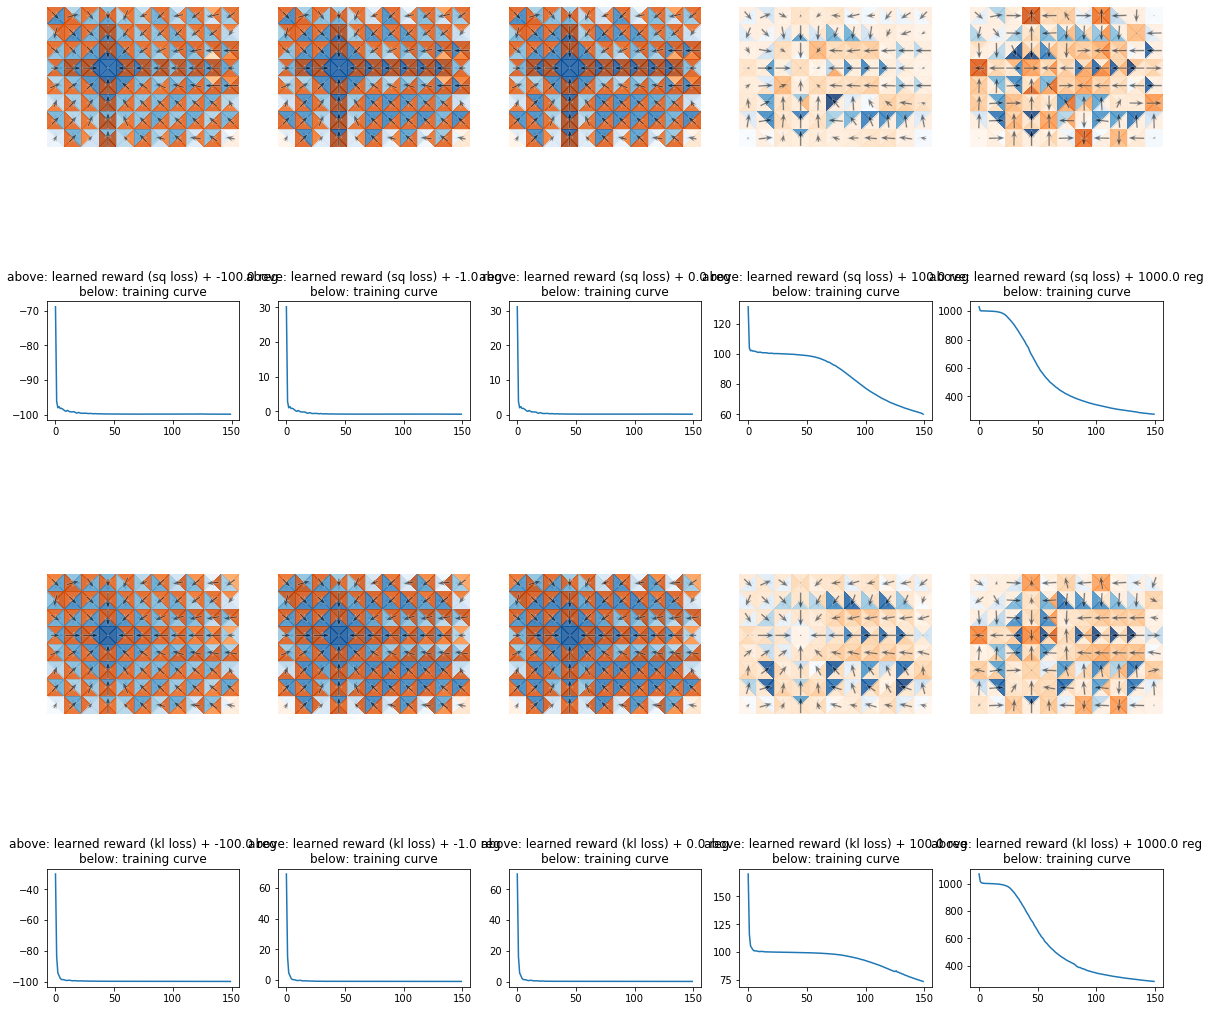

In [20]:
fig, AX = plt.subplots(4, 5, figsize=(20,20),  gridspec_kw={'height_ratios': [3,1,3,1]})

R_dipole = torch.zeros(GW.Sshape)
R_dipole[GW.S.idx(('x3', 'y3'))] = 1
R_dipole[GW.S.idx(('x1', 'y1'))] = -1

pi = prim.fwd(GW, R_dipole, 0.999, temp=0.001, val_iters=100)
# GW.draw(policy=pi, states=broadcompress(R_dipole), ax=ax?)
# ax?.set_title("Original Policy to Match, optimal for the given state reward")

for r,loss_fn in enumerate(['sq','kl']):
    for c,gdc in enumerate([-100, -1, 0, 100, 1000]):
        ax_r = AX[2*r,c]
        ax_tr = AX[2*r+1,c]

        R, losses = regularized_torch_IRL(GW, pi, 0.999, iters=150, goal_dir_coeff=gdc, loss_fn=loss_fn)
        piopt = prim.fwd(GW, R, 0.999, temp=0.001, val_iters=100)
        GW.draw(policy=piopt, tris=R.numpy(), ax=ax_r)

        ax_tr.plot(losses)
        # ax3.semilogy(torch_MCE_IRL.losses - numpy.min(torch_MCE_IRL.losses)+1)

        ax_tr.set_title("above: learned reward (%s loss) + %.1f reg\nbelow: training curve"% (loss_fn,gdc))
        # ax_tr.set_title("training curve: loss")
plt.show()

The most interesting thing here is the KL divergence curve for +100, which seems quite close to the original reward. Why is the regularization so large?

Original Policy to Match, optimal for the given state reward


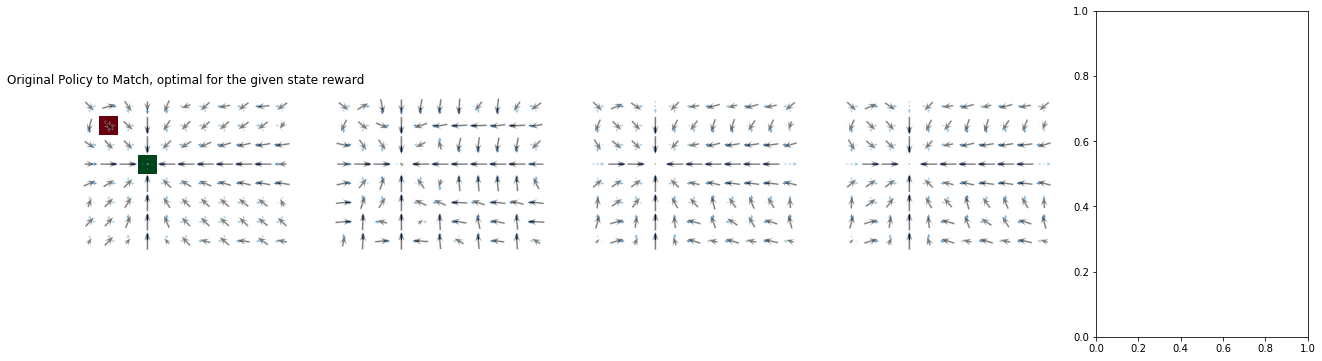

In [38]:

R_dipole = torch.zeros(GW.Sshape)
R_dipole[GW.S.idx(('x3', 'y3'))] = 1
R_dipole[GW.S.idx(('x1', 'y1'))] = -1

γ = 0.999

pi = prim.fwd(GW, R_dipole, γ, temp=0.001, val_iters=100)
R, losses = regularized_torch_IRL(GW, pi, γ, iters=150, goal_dir_coeff=100, loss_fn='kl')



ratio = 0.1
γsmall = γ * ratio
γbig = 1 + (γ - 1)*ratio
policyopt = prim.fwd(GW, R, γ, val_iters=100, temp=0.001)
policy_bigg = prim.fwd(GW, R, γbig, val_iters=100, temp=0.001)
policy_smallg = prim.fwd(GW, R, γsmall, val_iters=100, temp=0.001)


Original Policy to Match, optimal for the given state reward


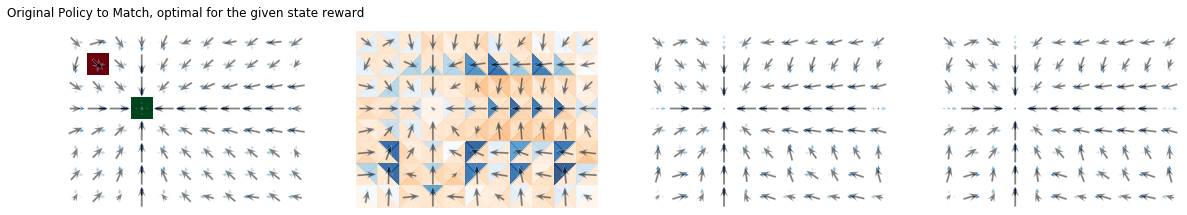

In [41]:
fig, AX = plt.subplots(1, 4, figsize=(20,5) )

GW.draw(policy=pi, states=broadcompress(R_dipole), ax=AX[0], descr="Original Policy to Match, optimal for the given state reward")
GW.draw(policy=policy_smallg, ax=AX[1])
GW.draw(policy=policyopt, ax=AX[2], tris=R.numpy())
GW.draw(policy=policy_bigg, ax=AX[3])



In [ ]:
## A Dirrerent Goal-Directedness Measure: distance from 

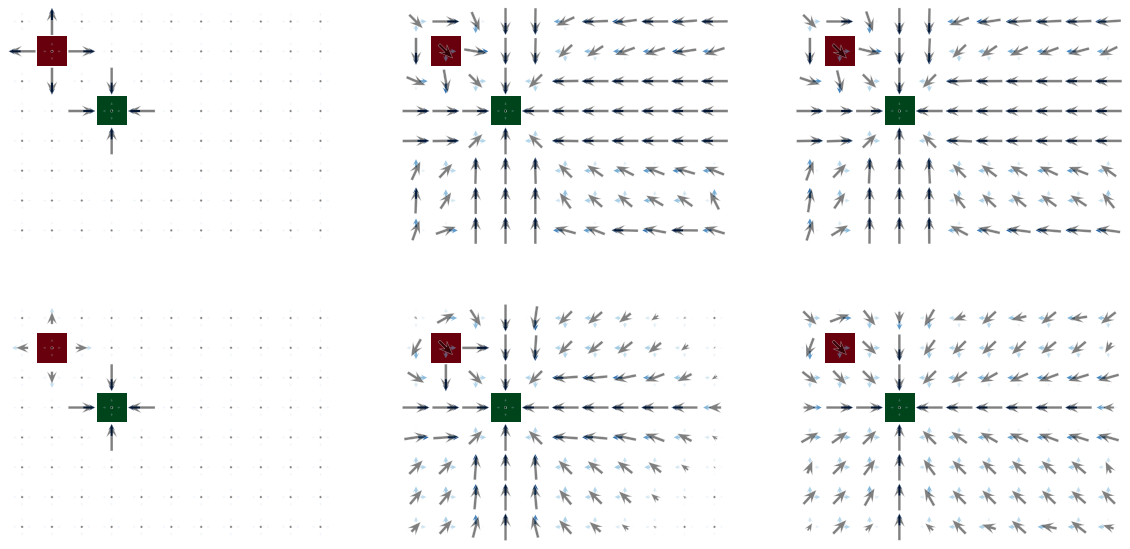

In [37]:
# !! Note: the number of value iterations is very important here. 

fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) =  plt.subplots(2, 3, figsize=(18,10))

GW.draw(states=R_dipole, policy=prim.fwd(GW, R_dipole, 0.9, val_iters=1, temp=0.001),ax=ax1)
GW.draw(states=R_dipole, policy=prim.fwd(GW, R_dipole, 0.9, val_iters=15, temp=0.001),ax=ax2)
GW.draw(states=R_dipole, policy=prim.fwd(GW, R_dipole, 0.9, val_iters=150, temp=0.001),ax=ax3)

GW.draw(states=R_dipole, policy=prim.fwd(GW, R_dipole, 0.01, val_iters=150, temp=0.001),ax=ax4)
GW.draw(states=R_dipole, policy=prim.fwd(GW, R_dipole, 0.5, val_iters=150, temp=0.001),ax=ax5)
GW.draw(states=R_dipole, policy=prim.fwd(GW, R_dipole, 0.999, val_iters=150, temp=0.001),ax=ax6)

This suggests an alternate approach, where we varry the number of steps, rather than gamma.

In [28]:
def reg_torch_IRL_alt1(env, desired_policy, γ, iters=100, lr=0.001, goal_dir_coeff=1, loss_fn='cos'):
    # the parameters are the rewards.
    # start with the zero reward
    R = torch.zeros(env.SAshape, requires_grad = True)

    optimizer = torch.optim.Adam([R], lr=lr)
    losses = []
    
    for it in range(iters):
        optimizer.zero_grad()
        # V = prim.value_iter(GW, R, γ, 100, temperature=0.001)
        # opt_policy = prim.best_policy(GW, R, V, γ, temperature=0.001)
        opt_policy = prim.fwd(GW, R, γ, val_iters=100, temp=0.001)

        # kl = (dp * torch.where(dp==0, 0., torch.log( torch.where(dp==0, 1., torch.div(dp, opt_policy+1e-8))))).sum()
        # mse = ((dp - opt_policy)**2).sum()
       
        loss = 0
        dp = desired_policy
        if 'cos' in loss_fn:  ## cosine similarity loss.
            loss = -(dp * opt_policy).sum() / torch.sqrt( (dp**2).sum() * (opt_policy**2).sum())
        if 'kl' in loss_fn: ##
            loss += (dp * torch.where(dp==0, 0., torch.log( torch.where(dp==0, 1., torch.div(dp, opt_policy+1e-8))))).sum()
        if 'sq' in loss_fn: ## square loss
            loss += ((dp - opt_policy)**2).sum()

        ratio = 0.1
        γsmall = γ * ratio
        γbig = 1 + (γ - 1)*ratio
        # print('small \gamma: ',γsmall, ' \t big gamma:', γbig)
        # policy_bigg = prim.fwd(GW, R, γbig, val_iters=100, temp=0.001)
        # policy_smallg = prim.fwd(GW, R, 0, val_iters=100, temp=0.001)
        myopic_policy = prim.fwd(GW, R, 0.5, val_iters=1, temp=0.001)

        ## Goal Directedness Regularization (cost for similarity)
        loss += goal_dir_coeff * (policy_bigg * policy_smallg).sum() / torch.sqrt( (policy_bigg**2).sum() * (policy_smallg**2).sum()) 
        ## L1 regularization
        # loss += torch.abs(R.sum(axis=1)).sum()
        ## Entropy Regularization
        # loss += 2* torch.where(opt_policy==0, 0., opt_policy*torch.log(torch.where(opt_policy==0, 1., opt_policy))).sum() / GW.nS

        loss.backward()
        losses.append(loss.detach())

        optimizer.step()

    return R.detach(), losses

# Emulating MCE IRL

In [ ]:
def torch_MCE_IRL(env, desired_policy, γ, iters=100, lr=0.001):
    # the parameters are the rewards.
    # start with the zero reward
    R = torch.zeros(env.SAshape, requires_grad = True)

    optimizer = torch.optim.Adam([R], lr=lr)
    losses = []
    
    for it in range(iters):
        optimizer.zero_grad()
        # V = prim.value_iter(GW, R, γ, 100, temperature=0.001)
        # opt_policy = prim.best_policy(GW, R, V, γ, temperature=0.001)
        opt_policy = prim.fwd(GW, R, γ, val_iters=100, temp=0.001)

        # kl = (dp * torch.where(dp==0, 0., torch.log( torch.where(dp==0, 1., torch.div(dp, opt_policy+1e-8))))).sum()
        # mse = ((dp - opt_policy)**2).sum()
        ## cosine similarity loss.
        loss = -(desired_policy * opt_policy).sum() / torch.sqrt( (desired_policy**2).sum() * (opt_policy**2).sum())

        ratio = 0.1
        γsmall = γ * ratio
        γbig = 1 + (γ - 1)*ratio
        print('small \gamma: ',γsmall, ' \t big gamma:', γbig)
        policy_bigg = prim.fwd(GW, R, γbig, val_iters=100, temp=0.001)
        policy_smallg = prim.fwd(GW, R, γsmall, val_iters=100, temp=0.001)

        ## Goal Directedness Regularization
        loss -= goal_dir_coeff * (policy_bigg * policy_smallg).sum() / torch.sqrt( (policy_bigg**2).sum() * (policy_smallg**2).sum()) 
        ## L1 regularization
        # loss += torch.abs(R.sum(axis=1)).sum()
        ## Entropy Regularization
        # loss += 2* torch.where(opt_policy==0, 0., opt_policy*torch.log(torch.where(opt_policy==0, 1., opt_policy))).sum() / GW.nS

        loss.backward()
        losses.append(loss.detach())

        optimizer.step()

    return R.detach(), losses